In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import torch
from torchaudio.datasets import YESNO as YESNO
from torchaudio.transforms import MelSpectrogram, MFCC, AmplitudeToDB
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary


# YESNO-MFCC-CNN

In [11]:
config = {
    'batch_size': 377,
    'shuffle': True,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'learning_rate': 0.01,
    'epochs': 100,
    'save_path': './models',
}

In [12]:
raw_data = YESNO('datasets', download=True)
# waveform, sample_rate, label
waveform, sr, label = raw_data[21]
Audio(waveform, rate=sr)

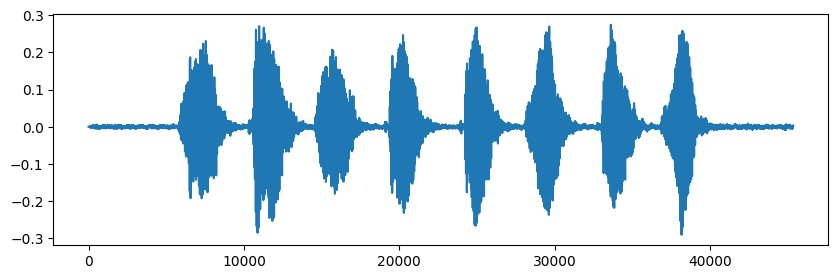

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(waveform.t().numpy())
plt.show()


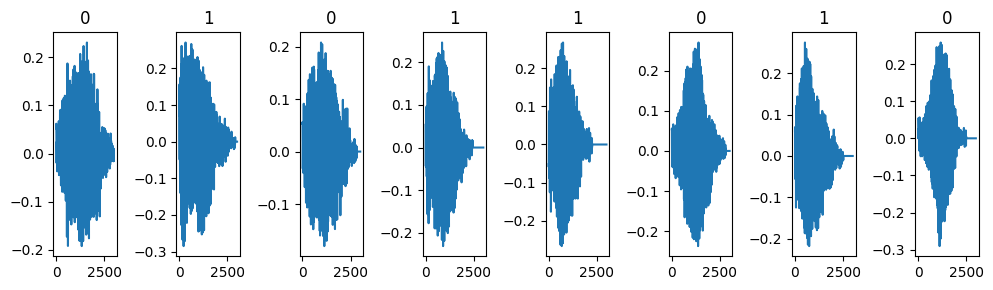

In [14]:
# split wave
def split_wave(waveform, label, thr = 0.1):
    waveform = waveform.numpy().squeeze()
    thr = waveform.mean() + waveform.std()
    start_idx = []
    end_idx = []
    start_flag = False
    end_cnt = 0
    for i in range(len(waveform)):
        if np.abs(waveform[i]) >= thr:
            end_cnt = 0
            if start_flag == False:
                start_flag = True
                start_idx.append(i)
        elif np.abs(waveform[i]) < thr and start_flag == True:
            end_cnt += 1
            if end_cnt == 499:
                end_idx.append(i)
                start_flag = False
                end_cnt = 0
    sub_waves = []
    sub_labels = []
    for idx in range(len(label)):
        x = waveform[start_idx[idx]:end_idx[idx]]
        # zero padding for x
        if len(x) < 3000:
            x = np.concatenate([x, np.zeros(3000 - len(x))])
        else:
            x = x[:3000]
        sub_waves.append(x)
        sub_labels.append(label[idx])

    return sub_waves, sub_labels

waves, labels = split_wave(raw_data[21][0], raw_data[21][2])

fig, axs = plt.subplots(1, 8, figsize=(10, 3))
for i in range(8):
    axs[i].plot(waves[i])
    axs[i].set_title(labels[i])

plt.tight_layout()
plt.show()


In [15]:
x = []
y = []
x_tensor = []

transform = MelSpectrogram(sr)

for idx in range(len(raw_data)):
    waveform, sr, label = raw_data[idx]
    waves, labels = split_wave(waveform, label)

    x.extend(waves)
    y.extend(labels)


In [16]:
train_data, test_data, train_label, test_label = train_test_split(x, y, test_size=0.2, random_state=42)

train_dataloader = DataLoader(list(zip(train_data, train_label)), batch_size=config['batch_size'], shuffle=config['shuffle'])
test_dataloader = DataLoader(list(zip(test_data, test_label)), batch_size=config['batch_size'], shuffle=config['shuffle'])


In [17]:
class YESNO_net(torch.nn.Module):
    def __init__(self):
        super(YESNO_net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 5)
        self.conv2 = torch.nn.Conv2d(4, 4, 5)
        self.conv3 = torch.nn.Conv2d(4, 1, 5)
        self.fc1 = torch.nn.Linear(1 * 4 * 116, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(-1, 1 * 4 * 116)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
model = YESNO_net().to(config['device'])
summary(model, input_size=(config['batch_size'], 1, 128, 16))


Layer (type:depth-idx)                   Output Shape              Param #
YESNO_net                                [377, 1]                  --
├─Conv2d: 1-1                            [377, 4, 124, 12]         104
├─ReLU: 1-2                              [377, 4, 124, 12]         --
├─Conv2d: 1-3                            [377, 4, 120, 8]          404
├─ReLU: 1-4                              [377, 4, 120, 8]          --
├─Conv2d: 1-5                            [377, 1, 116, 4]          101
├─ReLU: 1-6                              [377, 1, 116, 4]          --
├─Linear: 1-7                            [377, 64]                 29,760
├─ReLU: 1-8                              [377, 64]                 --
├─Linear: 1-9                            [377, 1]                  65
├─Sigmoid: 1-10                          [377, 1]                  --
Total params: 30,434
Trainable params: 30,434
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 233.47
Input size (MB): 3.09
Forward/backwa

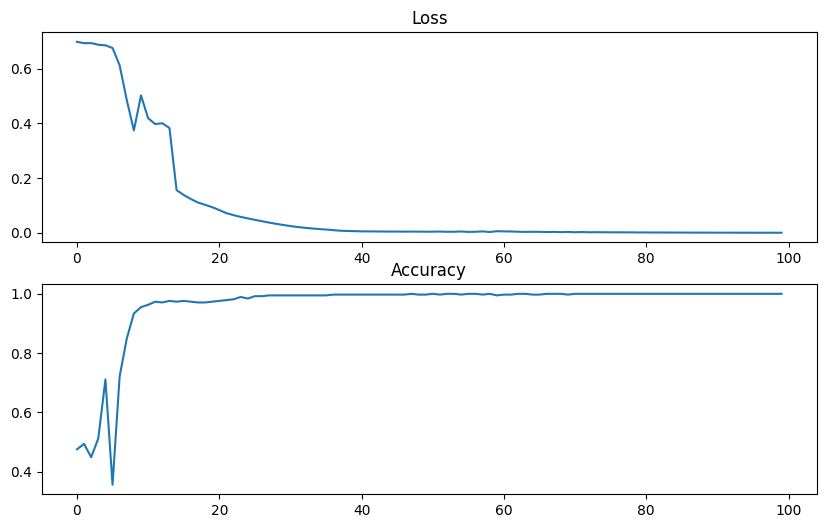

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
loss_hist = []
acc_hist = []

for epoch in range(config['epochs']):
    transform = MelSpectrogram(sr)
    transform = transform.to(config['device'])
    model = model.to(config['device'])
    running_loss = 0.0
    running_acc = 0.0
    for i, (x, y) in enumerate(train_dataloader):
        # calculate melspect of x
        mel_spec = []
        x = x.unsqueeze(1).to(config['device'])  # Ensure x is on the same device as the model
        for i in range(x.shape[0]):
            mel_spec.append(transform(x[i].float()))
        x = torch.stack(mel_spec)

        x = x.to(config['device'])
        y = y.to(config['device']).float()
        output = model(x)
        output = output.squeeze()        
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (output.round() == y).float().sum()

    loss_hist.append(running_loss)
    acc_hist.append(running_acc.item()/len(train_data))

    # print(f'Epoch {epoch + 1}, Loss: {running_loss}, Acc: {running_acc / len(train_data)}')

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(loss_hist)
axs[0].set_title('Loss')
axs[1].plot(acc_hist)
axs[1].set_title('Accuracy')
plt.show()


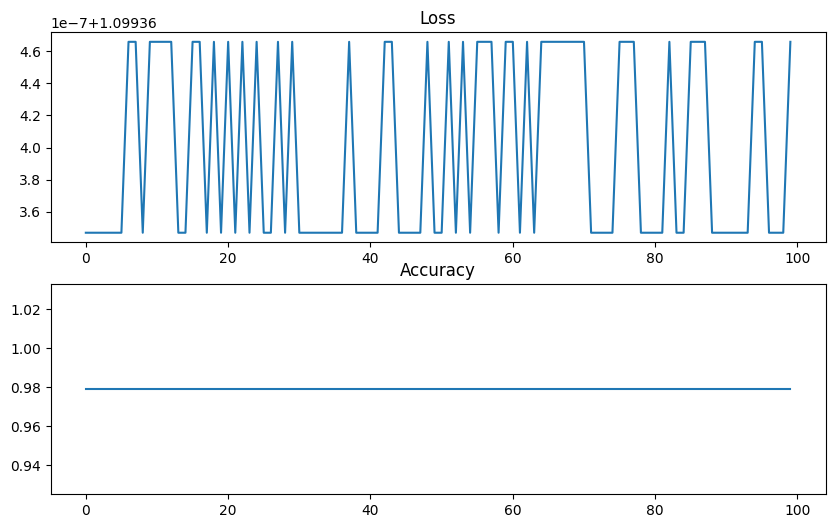

In [ ]:
# testing
loss_hist = []
acc_hist = []

for epoch in range(config['epochs']):
    transform = MelSpectrogram(sr)
    transform = transform.to(config['device'])
    model = model.to(config['device'])
    running_loss = 0.0
    running_acc = 0.0
    for i, (x, y) in enumerate(test_dataloader):
        # calculate melspect of x
        mel_spec = []
        x = x.unsqueeze(1).to(config['device'])  # Ensure x is on the same device as the model
        for i in range(x.shape[0]):
            mel_spec.append(transform(x[i].float()))
        x = torch.stack(mel_spec)

        x = x.to(config['device'])
        y = y.to(config['device']).float()
        output = model(x)
        output = output.squeeze()        
        loss = criterion(output, y)

        running_loss += loss.item()
        running_acc += (output.round() == y).float().sum()

    loss_hist.append(running_loss)
    acc_hist.append(running_acc.item()/len(test_data))

    # print(f'Epoch {epoch + 1}, Loss: {running_loss}, Acc: {running_acc / len(train_data)}')

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(loss_hist)
axs[0].set_title('Loss')
axs[1].plot(acc_hist)
axs[1].set_title('Accuracy')
plt.show()
